In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from PIL import Image
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
import os

In [2]:
mean = [0.5] * 3
std = [0.5] * 3
size = 128
transform = T.Compose([
    T.ToTensor(),
    T.Resize(size=(size,size), antialias=False),
    T.Normalize(mean, std)
])

# Dataset

In [3]:
class F2C_Dataset(Dataset):
    def __init__(self, path_face, path_comic):
        self.face_files = sorted(list(Path(path_face).rglob('*.jpg')))
        self.comic_files = sorted(list(Path(path_comic).rglob('*.jpg')))
        
        assert len(self.face_files) == len(self.comic_files)
        self.len_ = len(self.face_files)
        
    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        x, y = self.load_sample(self.face_files[index], self.comic_files[index])
        x, y = transform(x), transform(y)
        return x, y
        
    def load_sample(self, file1, file2=None):
        image1 = Image.open(file1)
        image1.load()
        if file2:
            image2 = Image.open(file2)
            image2.load()
            return image1, image2
        
        return image1   

In [4]:
path_f = "/kaggle/input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face"
path_c = "/kaggle/input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics"
f2c_ds = F2C_Dataset(path_f, path_c)

In [5]:
bs = 32
f2c_dl = DataLoader(f2c_ds, batch_size=bs, shuffle=True)

In [6]:
def denorm(img_tensors):
    return list(map(lambda x: x * mean[0] + std[0], img_tensors))

def img_to_show(img_tensor, denorm=True):
    if denorm:
        img_tensor = img_tensor * mean[0] + std[0]
    return np.rollaxis(img_tensor.numpy(), 0, 3)

def show_images(f, c, nmax=32):
    images = []
    for i in range(len(f)):
        images.append(f[i])
        images.append(c[i])
    #images = np.array(images)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for face, comic in dl:
        show_images(face, comic, nmax)
        break

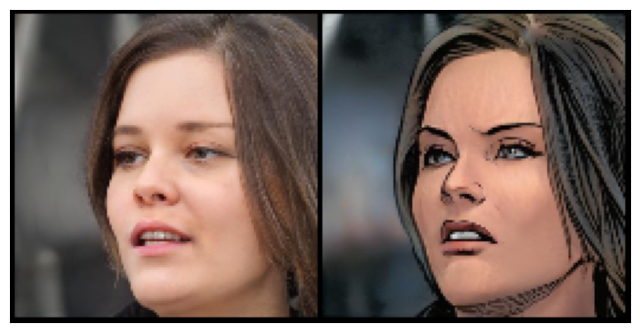

In [7]:
show_batch(f2c_dl, 2)

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# Model

## Blocks

In [10]:
class Encode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,
                      padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, True)
        )
    def forward(self, x):
        return self.encode(x)

    
class Pool2(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        # in_ch x in_ch -> in_ch / 2 x in_ch / 2
        self.pooling = nn.Conv2d(in_channels,in_channels,
                                 kernel_size=4, stride=2, padding=1,
                                 padding_mode='reflect')
    
    def forward(self, x):
        return self.pooling(x)


class Decode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=3,
                      padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(in_channels),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, True)
        )
    def forward(self, x):
        return self.decode(x)
    
    
class Unpool2(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        # in_ch x in_ch -> in_ch * 2 x in_ch * 2
        self.unpooling = nn.ConvTranspose2d(in_channels, in_channels,
                                            kernel_size=4, stride=2, padding=1)
    
    def forward(self, x, output_size):
        return self.unpooling(x, output_size=output_size)
    
    
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2)                              :
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=4, stride=stride, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, True),
        )

    def forward(self, x):
        return self.conv(x)

## Generator

In [11]:
# U-net generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Downsampling
        
        # 128 -> 64
        self.encode0 = Encode(3, 64)
        self.pool0 = Pool2(64)
        
        # 64 -> 32
        self.encode1 = Encode(64, 128)
        self.pool1 = Pool2(128)
        
        # 32 -> 16
        self.encode2 = Encode(128, 256)
        self.pool2 = Pool2(256)
        
        # 16 -> 8
        self.encode3 = Encode(256, 512)
        self.pool3 = Pool2(512)
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(1024),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),
        )
        
        # Upsampling
        
        # 8 -> 16
        self.unpool0 = Unpool2(512)
        self.decode0 = Decode(512, 256)
        
        # 16 -> 32
        self.unpool1 = Unpool2(256)
        self.decode1 = Decode(256, 128)
        
        # 32 -> 64
        self.unpool2 = Unpool2(128)
        self.decode2 = Decode(128, 64)
        
        # 64 -> 128
        self.unpool3 = Unpool2(64)
        self.decode3 = nn.Sequential(  # without last LeakyReLU
            nn.Conv2d(64 * 2, 64, kernel_size=3, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(3),
        )
        
    def forward(self, x):
        # encoder
        skip0 = self.encode0(x)
        e0 = self.pool0(skip0)

        skip1 = self.encode1(e0)
        e1 = self.pool1(skip1)

        skip2 = self.encode2(e1)
        e2 = self.pool2(skip2)

        skip3 = self.encode3(e2)
        e3 = self.pool3(skip3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.decode0(torch.cat(
            [self.unpool0(b, output_size=skip3.size()), skip3], dim=1))
        d1 = self.decode1(torch.cat(
            [self.unpool1(d0, output_size=skip2.size()), skip2], dim=1))
        d2 = self.decode2(torch.cat(
            [self.unpool2(d1, output_size=skip1.size()), skip1], dim=1))
        d3 = self.decode3(torch.cat(
            [self.unpool3(d2, output_size=skip0.size()), skip0], dim=1))
        
        return d3

## PathGAN (Discriminator)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.init = nn.Sequential(  # 128 -> 64
            nn.Conv2d(3*2, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2, True),
        )
        self.conv = nn.Sequential(
            CNNBlock(64, 128),  # 64 -> 32
            CNNBlock(128, 256),  # 32 -> 16
            CNNBlock(256, 512),  # 16 -> 8
            CNNBlock(512, 512),  # 8 -> 4
        )
      
        self.pred = nn.Conv2d(512, 1, kernel_size=4, stride=1)
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        
        x = self.init(x)
        x = self.conv(x)
        return self.pred(x)
    

# Train

In [13]:
# test
def test(model, data_loader):
    model["generator"].eval()
    print("Test:")
    for x_val, y_val in data_loader:

        torch.cuda.empty_cache()
        gc.collect()
        
        num = x_val.shape[0]

        y_val_fake = model["generator"](x_val.to(device)).detach().cpu()
        for k in range(num):
            
            plt.subplot(3, num, k+1)
            plt.imshow(img_to_show(x_val[k]))
            plt.title('Real')
            plt.axis('off')
            
            plt.subplot(3, num, k+1+num)
            plt.imshow(img_to_show(y_val_fake[k]))
            plt.title('Fake')
            plt.axis('off')

            plt.subplot(3, num, k+1+num*2)
            plt.imshow(img_to_show(y_val[k]))
            plt.title('Ground Truth')
            plt.axis('off')

        break

In [14]:
def plot_losses(loss_g, loss_d):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].plot(loss_g, label='generator loss')
    ax[1].plot(loss_d, label='discriminator loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    ax[0].legend()
    ax[1].legend()
    
    plt.show()

In [15]:
def save_model(model, path_d='disriminator.pt', path_g='generator.pt'):
    
    torch.save(model["discriminator"].state_dict(), path_d)
    torch.save(model["generator"].state_dict(), path_g)
        
def load_model(model, path_d='/kaggle/working/disriminator.pt', path_g='/kaggle/working/generator.pt'):
    
    model["discriminator"].load_state_dict(torch.load(path_d, map_location=device))
    model["generator"].load_state_dict(torch.load(path_g, map_location=device))

In [16]:
bs = 32
f2c_dl = DataLoader(f2c_ds, batch_size=bs, shuffle=True, num_workers=2)
test_dl = DataLoader(f2c_ds, batch_size=4, shuffle=True, num_workers=2)
device_dl = DeviceDataLoader(f2c_dl, device)

In [17]:
model = {
    "discriminator": Discriminator().to(device),
    "generator": Generator().to(device)
}

In [18]:
criterion_bce = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

lr = 1e-7
L1_LAMBDA = 120

lambda1 = lambda epoch: 0.3 ** epoch

optim_d = optim.Adam(model["discriminator"].parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(model["generator"].parameters(), lr=lr, betas=(0.5, 0.999))

scheduler_d = torch.optim.lr_scheduler.LambdaLR(optim_d, lr_lambda=lambda1)
scheduler_g = torch.optim.lr_scheduler.LambdaLR(optim_g, lr_lambda=lambda1)

In [19]:
load_model(model, '/kaggle/input/pix2pix128/disriminator.pt', '/kaggle/input/pix2pix128/generator.pt')

Test:


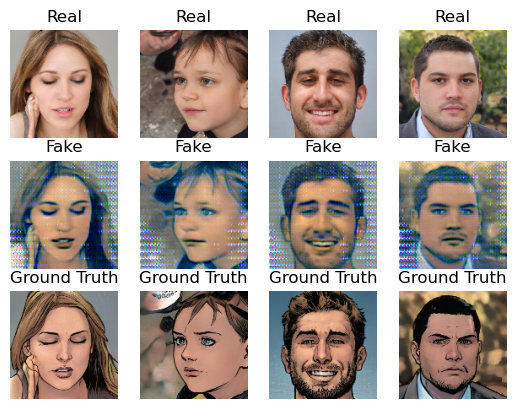

In [20]:
test(model, test_dl)

In [49]:
torch.cuda.empty_cache()
gc.collect()

27029

In [31]:
losses_d = []
losses_g = []

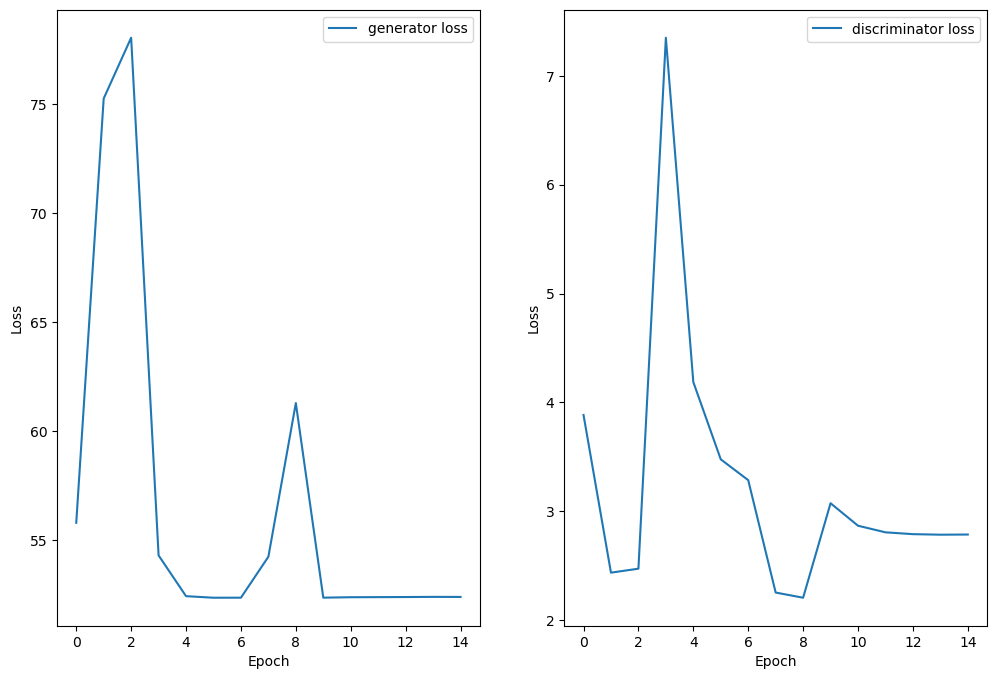

Epoch 7:


  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
epochs = 20
min_gen_loss = min(losses_g) if losses_g else np.inf

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}:")
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    
    for x, y in tqdm(device_dl):
        
        # Train discriminator
        y_fake = model["generator"](x)
        p_real = model["discriminator"](x, y)
        p_fake = model["discriminator"](x, y_fake.detach())
        
        loss_d_real = criterion_bce(p_real, torch.ones_like(p_real).to(device))
        loss_d_fake = criterion_bce(p_fake, torch.zeros_like(p_fake).to(device))
        loss_d = loss_d_real + loss_d_fake
        
        optim_d.zero_grad()
        loss_d.backward()
        optim_d.step()
        
        loss_d_per_epoch.append(loss_d.item())
        
        # Train generator
        p_fake = model["discriminator"](x, y_fake)
        loss_g_fake = criterion_bce(p_fake, torch.ones_like(p_fake).to(device))
        loss_g_l1 = criterion_l1(y_fake.detach(), y) * L1_LAMBDA
        
        loss_g = loss_g_fake + loss_g_l1
        
        optim_g.zero_grad()
        loss_g.backward()
        optim_g.step()
        
        loss_g_per_epoch.append(loss_g.item())
        
        torch.cuda.empty_cache()
        gc.collect()
        
    scheduler_d.step()
    scheduler_g.step()
    losses_d.append(np.mean(loss_d_per_epoch))
    losses_g.append(np.mean(loss_g_per_epoch))
    
    if losses_g[-1] < min_gen_loss:
        save_model(model)
    
    clear_output(True)
    plot_losses(losses_g, losses_d)
    
# report (losses, graphs, pictures)
clear_output(True)

# validation
test(model, test_dl)



In [26]:
save_model(model)

In [49]:
load_model(model)

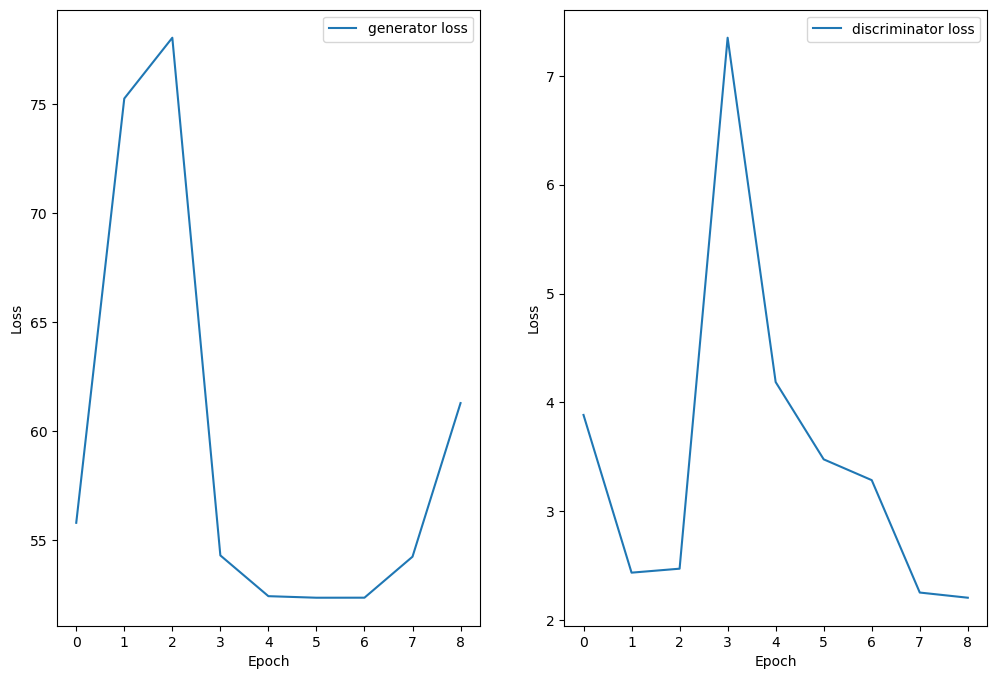

In [42]:
plot_losses(losses_g, losses_d)

Test:


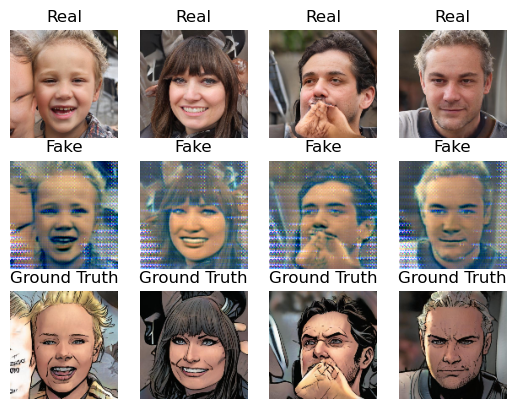

In [21]:
test(model, test_dl)

# TG Bot

In [22]:
!pip install aiogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 64.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: Babel
    Found existing installation: Babel 2.12.1
    Uninstalling Babel-2.12.1:
      Successfully uninstalled Babel-2.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.22.1 requires babel>=2.10, but you have babel 2.9.1 which is incompatible.


In [ ]:
!python3 /kaggle/input/gan-tg-bot/bot.py

/opt/conda/lib/python3.10/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
/opt/conda/lib/python3.10/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
/opt/conda/lib/python3.10/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
/opt/conda/lib/python3.10/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
/opt/conda/lib/python3.10/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
